# Q-learning: cliff walking

![](https://www.gymlibrary.dev/_images/cliff_walking.gif)

In [4]:
## Import Libraries
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

In [5]:
## Initialize the CliffWalking environment
env = gym.make('CliffWalking-v1')

In [6]:
## Set up Q-learning parameters
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

q_table = np.zeros((state_space_size, action_space_size))

num_episodes = 5000
max_steps_per_episode = 100

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

rewards_all_episodes = []

In [7]:
## Q-Learning algorithm
for episode in range(num_episodes):
    state, _ = env.reset()              # ← unpack both values
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode):

        # ε-greedy action
        if random.random() > exploration_rate:
            action = np.argmax(q_table[state, :])
        else:
            action = env.action_space.sample()

        # NEW: 5-tuple
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated   # treat either signal as “episode finished”

        # Q-update
        q_table[state, action] = (
            (1 - learning_rate) * q_table[state, action] +
            learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
        )

        state = new_state
        rewards_current_episode += reward
        if done:
            break

    # ε decay
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)

    rewards_all_episodes.append(rewards_current_episode)


In [8]:
## Calculate and print the average reward per thousand episodes
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes), num_episodes/1000)
count = 1000

print("Average reward per thousand episodes")
for r in rewards_per_thousand_episodes:
    print(count, ": ", str(sum(r/1000)))
    count += 1000

Average reward per thousand episodes
1000 :  -575.6670000000007
2000 :  -136.431
3000 :  -47.67499999999999
4000 :  -26.07300000000045
5000 :  -20.947000000000344


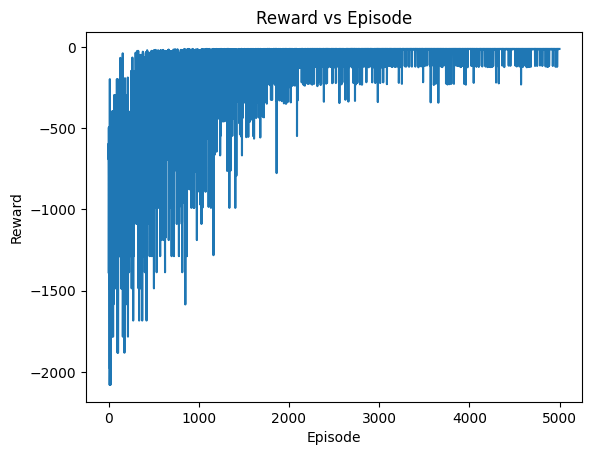

In [9]:
## Plotting the results
plt.plot(range(num_episodes), rewards_all_episodes)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward vs Episode')
plt.show()

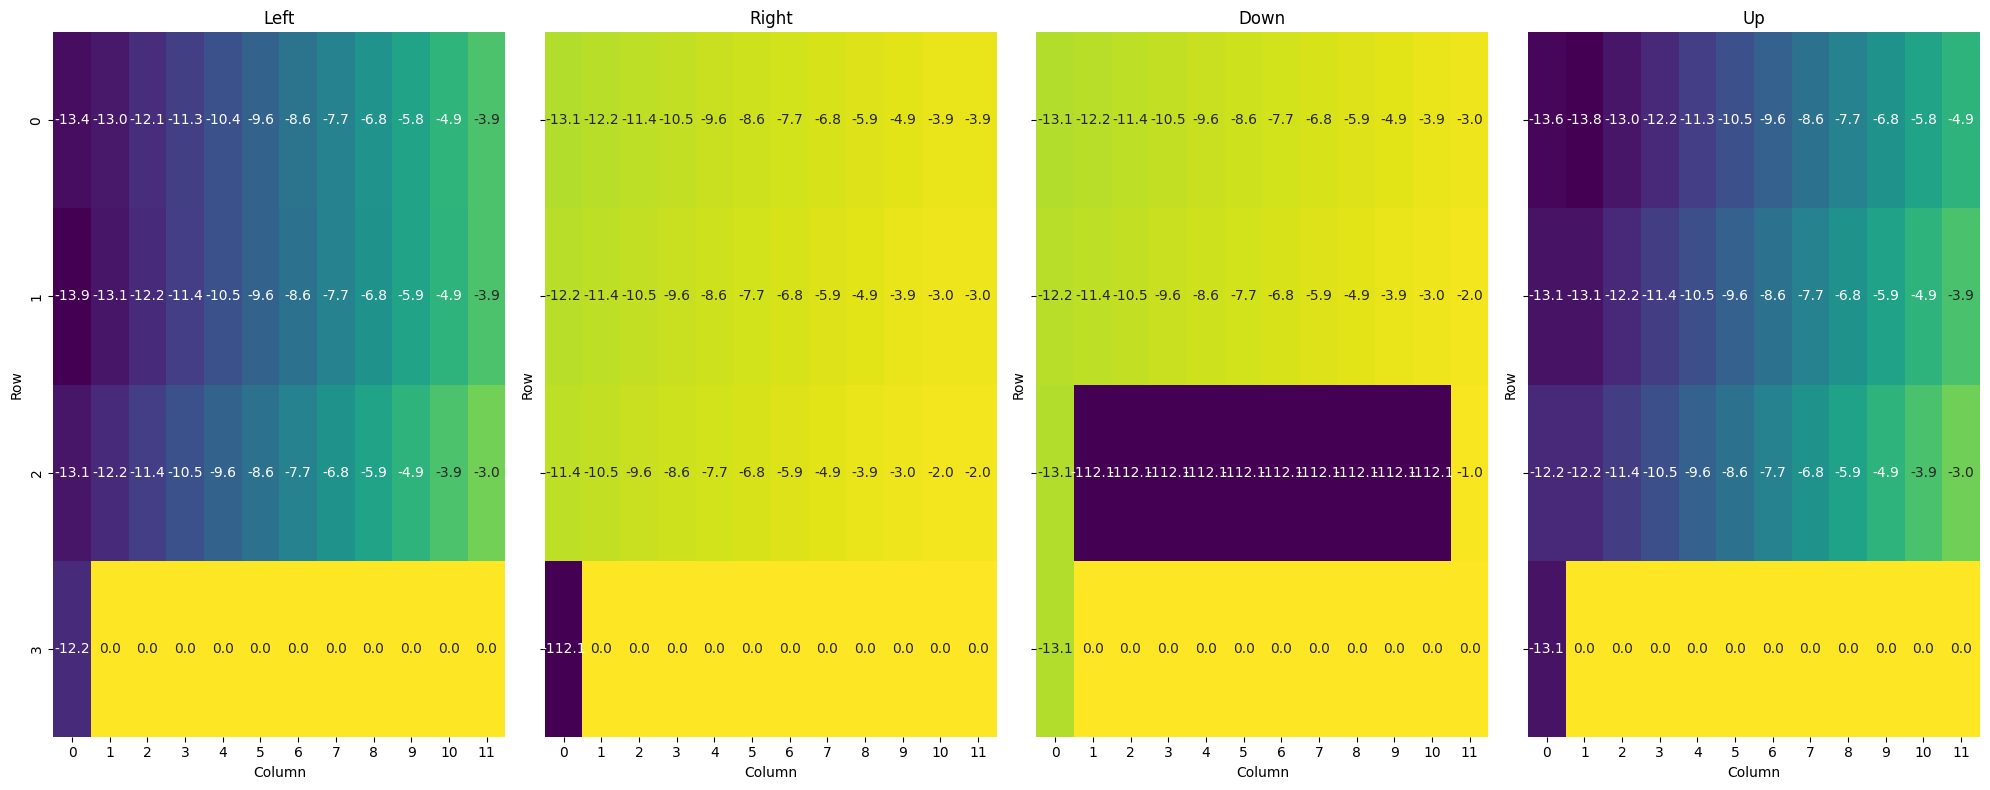

In [10]:
## Visualize the Q-table as heatmap - one for each action up, right, down, left

def plot_q_values_heatmaps(q_table):
    num_states = q_table.shape[0]
    num_actions = q_table.shape[1]

    grid_size = (4, 12)  # CliffWalking-v1 has a 4x12 grid
    fig, axes = plt.subplots(1, num_actions, figsize=(20, 8), sharex=True, sharey=True)

    actions = ['Left', 'Right', 'Down', 'Up']  # Corresponding to each action
    for action in range(num_actions):
        q_values_grid = np.zeros(grid_size)

        for state in range(num_states):
            row, col = divmod(state, grid_size[1])
            q_values_grid[row, col] = q_table[state, action]

        sns.heatmap(q_values_grid, cmap='viridis', annot=True, fmt=".1f", ax=axes[action], cbar=False)
        axes[action].set_title(actions[action])
        axes[action].set_xlabel('Column')
        axes[action].set_ylabel('Row')

    plt.tight_layout()
    plt.show()

plot_q_values_heatmaps(q_table)

In [21]:
## Function to visualize the agent's movement
def visualize_agent_path(env, q_table, max_steps=max_steps_per_episode):
    grid_size = (4, 12)                    # CliffWalking is 4×12
    arrow = ['↑', '↓', '←', '→']           # 0=Left, 1=Down, 2=Right, 3=Up

    # --- new Step API ------------------------------------------------------
    state, _ = env.reset()                 # observation, info
    path   = []
    for _ in range(max_steps):
        action = np.argmax(q_table[state]) # best action in this state

        row, col = divmod(state, grid_size[1])
        path.append((row, col, arrow[action]))

        state, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:        # episode finished?
            break
    # ----------------------------------------------------------------------

    # simple visualisation --------------------------------------------------
    import matplotlib.pyplot as plt
    grid = np.zeros(grid_size)
    for r, c, _ in path:
        grid[r, c] = 1
    plt.imshow(grid, cmap='viridis', interpolation='none')
    plt.title('Agent path')
    plt.colorbar()
    plt.show()


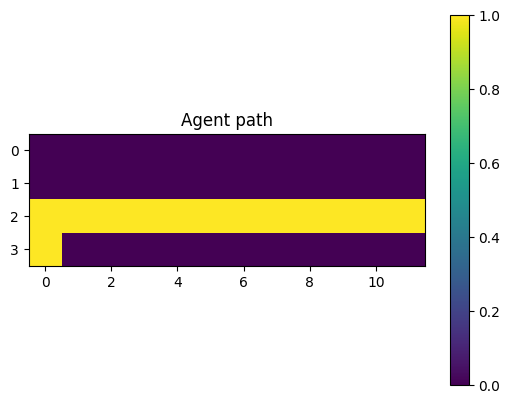

In [22]:
## Run the visualization
visualize_agent_path(env, q_table)